The below cells of code are used to create a Logistic Regression model to predict if a flight out of an aiport with the US will be delayed or not. The first cell of code imports needed packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.preprocessing import StandardScaler,RobustScaler,PowerTransformer #importing all scalers used
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC,NuSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time
import lightgbm as lgb

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [4]:
pd.set_option('display.max_columns', None)

After importing the merged file, airline_merged.csv, that was created in the ipynb file, airline_files_merge, we needed to remove the addditional column(Unnamed: 0) that is added in the export. 

In [5]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

The below cell creates a correlation matrix using all of the numerical columns and removes any column that has a correlation coeffecient that is greater than 0.90. This will eventually help decrease the amount of columns that are used in the model and help with any assumptions that need to be met.

In [6]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [7]:
#looking at dataframe after removing highly correlated fields.
df.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,5,-11.0,21.0,205.0,404.0,4.0,430,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,American Airlines Inc.,2336,N3KUAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,10,-8.0,12.0,280.0,737.0,4.0,750,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,US Airways Inc.,840,N171US,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,20,-2.0,16.0,286.0,800.0,11.0,806,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,American Airlines Inc.,258,N3HYAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,20,-5.0,15.0,285.0,748.0,8.0,805,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,Alaska Airlines Inc.,135,N527AS,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,25,-1.0,11.0,235.0,254.0,5.0,320,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Since the data set is quite large and personal laptops will struggle to churn through the amount of rows and columns, we decided to filter down the data to Dallas-Fort Worth International Airport. This decreased the data frame size from almost 6 million rows to just under 240k rows and also helped with the one hot encoding below.

In [8]:
#selecting 5 busiest airports in US
#airports = ['ATL','DFW','ORD','LAX','DEN']
#airports = ['DFW']
airports = ['BHM']

In [9]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [10]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12338.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,9.032906,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,14.805921,0.091635,20.292293,27.732613,2.580827
std,0.0,3.384375,8.763785,1.992624,1951.952017,7.787860e-12,1.647104e-11,4.990106,8.325266,445.126945,43.869223,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,32.820428,3.167858,73.036267,47.048389,16.190917
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,3.000000,0.000000,0.000000,9.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,18.000000,0.000000,10.000000,34.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [11]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

Because we want to predict if an airplane is going to be delayed or not using logistic regression, we created a new field called "is_delay" from the "departure_delay" field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

In [12]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

After creating the "is_delay" field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400. 

In [13]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [14]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

#head(final_df)

Once the target variable was created and we one hot encoded the data set, we were able to begin modeling our data. To start, we separated the features with the target varibale as to not leave the response in a test or train data set.

In [15]:
#remove target variable and column target was created from training data set
target_cols = ['is_delay','departure_delay']
feature_cols = final_df.loc[:, ~final_df.columns.isin(target_cols)].columns
X = final_df[feature_cols] # Features
y = final_df.is_delay # Target variable

In [16]:
classes = pd.value_counts(final_df["is_delay"], sort=True).sort_index()
print(classes)



0    8412
1    4102
Name: is_delay, dtype: int64


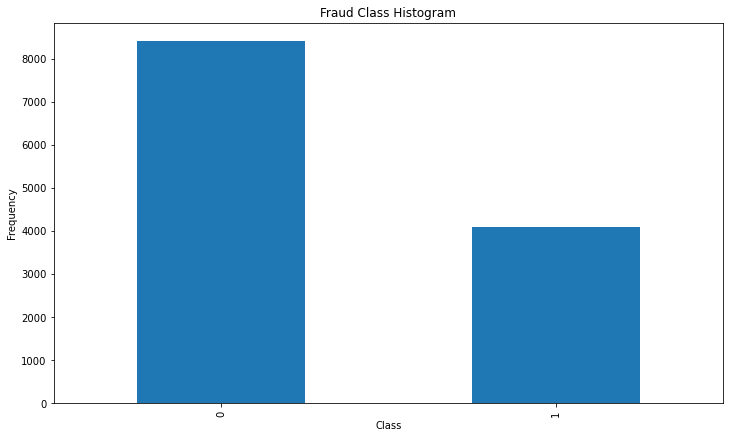

In [17]:
classes.plot(kind='bar', figsize=(12,7))
plt.title("Fraud Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show();

From sklearn, we used their train_test_split package to create a 75/25 train and test split for our model.

In [18]:
#split dataset in features and target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

After one hot encoding, for our logistic regession model to run, we imputed the NaN values with 0.

In [19]:
#imputing 0 into NaN values for logistic regression after OHE
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [20]:
#checking shape of data
print('X_train shape: ',X_train.shape,'\n')
print('X_test shape: ',X_test.shape,'\n')
print('y_train shape: ',y_train.shape,'\n')
print('y_test shape: ',y_test.shape)

X_train shape:  (10011, 1789) 

X_test shape:  (2503, 1789) 

y_train shape:  (10011,) 

y_test shape:  (2503,)


To simplify the code and useability of the model, we used a pipeline function from sklearn to standardize (using StandarScaler), run the data through PCA and then finally a logistic regession model using the PCA output. 

In [21]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components = .95)

# Define a Standard Scaler to normalize inputs
scaler = RobustScaler()

njobs = -1
tolerance = 0.1
rs = 0
l1ratio = 0.5

# Scale -> PCA -> LR 
#logistic = LogisticRegression(solver = 'saga',
#                                random_state = rs,
#                                penalty ='elasticnet',
#                                l1_ratio = l1ratio,
#                                class_weight = 'balanced',
#                                tol = tolerance)

logistic = LogisticRegression()

pipe = Pipeline(steps=[("scaler", scaler),
                       ("pca", pca),
                       ("logistic", logistic)]
               )

pipe.fit(X_train,y_train)


Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=0.95)),
                ('logistic', LogisticRegression())])

After fitting the model, we then ran our test data set through to create predictions.

In [22]:
#predict
y_pred=pipe.predict(X_test)

After creating predictions on our test data set, we pulled metrics to determine how well our model performed. Our base model had an accuracy of 78.31% with a precision of 95.99% and a recall of 51.54%. This model output gives us a good starting point for hypertuing the model and comparison against some more powerful models such as XGBoost or LightGBM. After computing these metrics we then created a confusion matrix heatmap to better visualize how well our model was predicting and where the model could perform better with False Positives and False Negatives.

In [23]:
#Metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8162205353575709
Precision: 0.9939393939393939
Recall: 0.4173027989821883


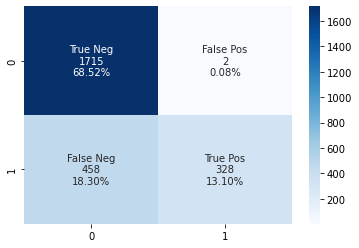

In [24]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

Finally we chose to plot a ROC curve to visualize specificity and sensitiviy of our model. 

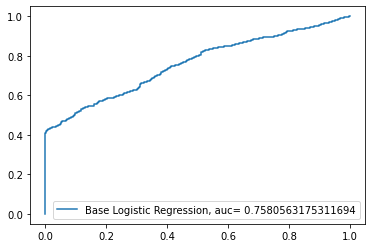

In [25]:
#ROC Curve
y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression, auc= "+str(auc))
plt.legend(loc=4)
plt.show()

***
# SVM Model
#### _SVC Package from Sklearn_


**_Accuracy_:**


In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
import time

In [27]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca_svm = PCA(n_components = .95)

# Define a Standard Scaler to normalize inputs
scaler_svm = StandardScaler()


# Scale -> PCA -> LR 
clf = SVC(kernel = 'linear',
         random_state = 0)

start = time.time()
pipe_svm = Pipeline(steps=[("scaler", scaler_svm),
                       ("pca", pca_svm),
                       ("SVM", clf)])

pipe_svm.fit(X_train,y_train)
end = time.time()

#predict
y_pred_svm=pipe_svm.predict(X_test)

runtime = end-start
accuracy_svm = metrics.accuracy_score(y_test,y_pred_svm)
precision_svm = metrics.precision_score(y_test, y_pred_svm)
recall_svm = metrics.recall_score(y_test, y_pred_svm)

#print results 
print('____________Start SVM Base Model Results______________:')
print('Runtime:\n',runtime,'\n')
print('Accuracy:\n',accuracy_svm,'\n')
print('Precision:\n',recall_svm,'\n')
print('Recall:\n',recall_svm,'\n')
print('____________End SVM Base Model Results________________')

____________Start SVM Base Model Results______________:
Runtime:
 59.29179310798645 

Accuracy:
 0.829005193767479 

Precision:
 0.48091603053435117 

Recall:
 0.48091603053435117 

____________End SVM Base Model Results________________


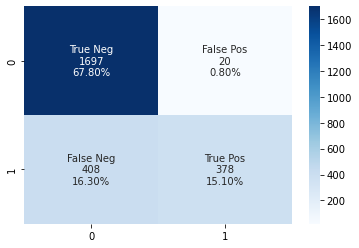

In [28]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

group_names_svm = ['True Neg','False Pos','False Neg','True Pos']

group_counts_svm = ["{0:0.0f}".format(value) for value in
                cf_matrix_svm.flatten()]

group_percentages_svm = ["{0:.2%}".format(value) for value in
                     cf_matrix_svm.flatten()/np.sum(cf_matrix_svm)]

labels_svm = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_svm,group_counts_svm,group_percentages_svm)]

labels_svm = np.asarray(labels_svm).reshape(2,2)

sns.heatmap(cf_matrix_svm, annot=labels_svm, fmt='', cmap='Blues');

***
## GridSearchCV with SVC Classifier
**Parameters with scoring = 'accuracy'**


1) Kernel: 
2) Decision Function Shape: **ovo**
3) Gamma: **auto**
4) Class Weight: **balanced**
5) Break Ties: 

**GridSearchCV Parameters decreased Accuracy by %**

In [29]:
from sklearn.model_selection import GridSearchCV
parameters = {
             'kernel':['linear', 'rbf'],
             'decision_function_shape':['ovo', 'ovr'],
             'gamma': ['scale','auto'],
             'class_weight': ['balanced']
             }
model = SVC(random_state = 0)
grid_search = GridSearchCV(estimator=model,
              param_grid=parameters,
              scoring = 'accuracy')
start_grid = time.time()
grid_search.fit(X_train, y_train)
end_grid = time.time()

print('________GridSearchCV Results:_________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_grid - start_grid, len(grid_search.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search.best_score_,'\n')


#print('GSCV Best Parameters:\n',grid_search.best_params_,'\n')

________GridSearchCV Results:_________

GridSearchCV took 6393.59 seconds for 8 candidate parameter settings.

GSCV Best Estimator:
 SVC(class_weight='balanced', decision_function_shape='ovo', gamma='auto',
    random_state=0) 

GSCV Best Score:
 0.8027176019188001 



***
## GridSearchCV with SVC Classifier
**Parameters with scoring = 'f1'**


1) Kernel: 
2) Decision Function Shape:
3) Gamma: 
4) Class Weight:
5) Break Ties: 

**GridSearchCV Parameters decreased Accuracy by %**

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
             'kernel':['linear', 'rbf'],
             'decision_function_shape':['ovo', 'ovr'],
             'gamma': ['scale','auto'],
             'class_weight': ['balanced']
             }
model = SVC(random_state =  0)
grid_search = GridSearchCV(estimator=model,
              param_grid=parameters,
              scoring = 'f1')
start_grid = time.time()
grid_search.fit(X_train, y_train)
end_grid = time.time()

print('________GridSearchCV Results:_________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_grid - start_grid, len(grid_search.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search.best_score_,'\n')

***
# SGDClassifier
### Base SGD Classifier:

In [ ]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a Standard Scaler to normalize inputs
scaler_sgd = StandardScaler()


# Scale -> PCA -> LR 
sgd = SGDClassifier(random_state = 0)
start_sgd = time.time()
pipe_sgd = Pipeline(steps=[("scaler", scaler_sgd),
                       ("SGD", sgd)])

pipe_sgd.fit(X_train,y_train)
end_sgd = time.time()

#predict
y_pred_sgd = pipe_sgd.predict(X_test)

runtime_sgd = end_sgd-start_sgd
accuracy_sgd = metrics.accuracy_score(y_test,y_pred_sgd)
precision_sgd = metrics.precision_score(y_test, y_pred_sgd)
recall_sgd = metrics.recall_score(y_test, y_pred_sgd)

#print results 
print('____________Start SGD Base Model Results______________:')
print('Runtime:\n',runtime_sgd,'\n')
print('Accuracy:\n',accuracy_sgd,'\n')
print('Precision:\n',precision_sgd,'\n')
print('Recall:\n',recall_sgd)
print('____________End SGD Base Model Results________________')

***
## Using GridSearchCV to hypertune


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
             'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
             'penalty':['l2', 'l1', 'elasticnet'],
             'learning_rate': ['optimal','adaptive'],
             'class_weight': ['balanced'],
             'eta0':[0.1,1.0,10.0,100]
             }

model = SGDClassifier(random_sate = 0)
grid_search = GridSearchCV(estimator=model,
              param_grid=parameters)

start_grid = time.time()
grid_search.fit(X_train, y_train)
end_grid = time.time()


print('________GridSearchCV Results:_________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_grid - start_grid, len(grid_search.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search.best_score_,'\n')
print('____________End Results:______________')

### **Using Hypertuned Parameters in SGDClasssifier**
**Parameters without scoring = 'accuracy'**

1) Loss: **modified_huber**
2) Penalty: **l1**
3) Learning Rate: **optimal**
4) Class Weight: **balanced**
5) Eta0: **0.1**


**GridSearchCV Parameters decreased Accuracy by 20%**


In [ ]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a Standard Scaler to normalize inputs
scaler_sgd = StandardScaler()

penalty_sgd = 'elasticnet'
njobs_sgd = -1
loss_sgd = 'modified_huber'
learningrate_sgd = 'adaptive'
classweight_sgd = 'balanced'
eta0_sgd = 0.001
tol_sgd = 0.0001
rs = 0
#scoring_sgd = 'neg_root_mean_squared_error'

# Scale -> SGDClassifier
sgd = SGDClassifier(loss = loss_sgd,
                    n_jobs = njobs_sgd,
                    penalty = penalty_sgd,
                    learning_rate = learningrate_sgd,
                    class_weight = classweight_sgd,
                    eta0 = eta0_sgd,
                    tol = tol_sgd,
                    #scoring = scoring_sgd,
                    random_state = rs
                   )

start_sgd = time.time()
pipe_sgd = Pipeline(steps=[("scaler", scaler_sgd),
                       ("SGD", sgd)])

pipe_sgd.fit(X_train,y_train)
end_sgd = time.time()

#predict
y_pred_sgd = pipe_sgd.predict(X_test)

runtime_sgd = end_sgd-start_sgd
accuracy_sgd = metrics.accuracy_score(y_test,y_pred_sgd)
precision_sgd = metrics.precision_score(y_test, y_pred_sgd)
recall_sgd = metrics.recall_score(y_test, y_pred_sgd)

#print results 
print('____________SGD Tuned Model Results______________:\n')
print('Runtime:\n',runtime_sgd,'\n')
print('Accuracy:\n',accuracy_sgd,'\n')
print('Precision:\n',precision_sgd,'\n')
print('Recall:\n',recall_sgd,'\n')
print('____________End SGD Tuned Model Results______________')

***
### **Using Hypertuned Parameters in SGDClasssifier**
**Parameters with scoring = 'accuracy'**


1) Loss: log
2) Penalty: l1
3) Learning Rate: NA
4) Class Weight: balanced
5) Eta0: 100


GSCV Best Score:
 **0.8020172039642833**
 
**GridSearchCV Parameters decreased Accuracy by 2%**

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
             'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
             'penalty':['l2', 'l1', 'elasticnet'],
             'learning_rate': ['optimal','adaptive'],
             'class_weight': ['balanced'],
             'eta0':[0.1,1.0,10.0,100]
             }
model = SGDClassifier(random_state = 0)
grid_search = GridSearchCV(estimator=model,
              param_grid=parameters,
              scoring = 'accuracy')

start_grid = time.time()
grid_search.fit(X_train, y_train)
end_grid = time.time()

print('________GridSearchCV Results:_________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_grid - start_grid, len(grid_search.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search.best_score_,'\n')

***
### **Using Hypertuned Parameters in SGDClasssifier**
**Parameters with scoring = 'f1'**


1) Loss: modified_huber
2) Penalty: l1
3) Learning Rate: 
4) Class Weight: balanced
5) eta0: 1

**GridSearchCV Parameters decreased Accuracy by 20%**

In [ ]:

parameters = {
             'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
             'penalty':['l2', 'l1', 'elasticnet'],
             'learning_rate': ['optimal','adaptive'],
             'class_weight': ['balanced'],
             'eta0': [0.01,0.1,1,10,100]
             }
model = SGDClassifier(random_state = 0 )
grid_search = GridSearchCV(estimator=model,
              param_grid=parameters,
              scoring = 'f1')
start_grid = time.time()
grid_search.fit(X_train, y_train)
end_grid = time.time()

print('________GridSearchCV Results:_________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_grid - start_grid, len(grid_search.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search.best_score_,'\n')

***
# Testing LightGBM
#### Running Data through LightGBM to determine if Logistic Regression or SVM performs better

In [ ]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a
#https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective

# Define a pipeline to search for the best combination of PCA truncation

from sklearn.cross_decomposition import PLSRegression

pca_lgbm = PCA(n_components = .95,
               svd_solver = 'auto')

# Define a Standard Scaler to normalize inputs

scaler_lgbm = RobustScaler()

lr = 0.15
boost = 'dart' #'gbdt' 
obj = 'binary'
tl = 'voting' # 'data'
numiter = 1000
mbin = 300
nleaves = 42


# Scale -> PCA -> LR 
lgbm = lgb.LGBMClassifier(learning_rate = lr,
                          boosting = boost,
                          objective = obj,
                          tree_learner = tl,
                          #num_iterations = numiter,
                          num_leaves = nleaves,
                          max_bin = mbin,
                          extra_trees = True)

start_lgbm = time.time()
pipe_lgbm = Pipeline(steps=[("scaler", scaler_lgbm),
                       ("pca", pca_lgbm),
                       ("LightGBM", lgbm)])

pipe_lgbm.fit(X_train,y_train)
end_lgbm = time.time()

#predict
y_pred_lgbm=pipe_lgbm.predict(X_test)

runtime_lgbm = end_lgbm-start_lgbm
accuracy_lgbm = metrics.accuracy_score(y_test,y_pred_lgbm)
precision_lgbm = metrics.precision_score(y_test, y_pred_lgbm)
recall_lgbm = metrics.recall_score(y_test, y_pred_lgbm)

#print results 
print('____________Start LightGBM Base Model Results______________:')
print('Runtime:\n',runtime_lgbm,'\n')
print('Accuracy:\n',accuracy_lgbm,'\n')
print('Precision:\n',recall_lgbm,'\n')
print('Recall:\n',recall_lgbm,'\n')
print('____________End LightGBM Base Model Results________________')